Title:
            Predicting Usage of a Video Game Research Server


INTRODUCTION

**`Background`** 
Video games have become a widely popular form of entertainment and a valuable source of behavioral data for researchers. Understanding how players interact with games can inform a variety of domains, from improving game design and user engagement to studying cognitive processes and soc/ial behavior in virtual environments.A research group in UBC’s Computer Science department is studying how people play video games by collecting data from a custom MineCraft server. Players' demographics, skill levels, and in-game behaviors are recorded to help answer questions about engagement and resource needs.

Running the server requires careful planning, especially in recruiting active participants and managing server capacity. One key question is whether it’s possible to predict which players will subscribe to the project’s newsletter, as a sign of ongoing interest and engagement. This project explores that question using real gameplay and demographic data.



**`Question:`** 
Can player demographics and gameplay behavior, such as age, gender, skill level, and total hours played—predict whether a player will subscribe to the game-related newsletter in the UBC Minecraft server dataset?



**`data description`**

To address the predictive question—Can player demographics and gameplay behavior predict newsletter subscription?—we used two datasets collected by a research group in the UBC Computer Science department. These datasets were gathered from a Minecraft server that logs player sessions and stores basic demographic information. 
### 1. Player Information (`players.csv`)

This dataset includes one row per player with demographic and experience-level data.

**Summary:**
- **Number of observations:** 196 players
- **Key issues:** 2 missing values in the `Age` column; some players have no playtime recorded.

| Variable             | Type                   | Description                                               |
|----------------------|------------------------|-----------------------------------------------------------|
| `hashedEmail`        | Identifier             | Anonymized player ID used to link datasets                |
| `experience`         | Categorical (string)   | Player’s skill level (e.g., Pro, Veteran, Amateur)        |
| `subscribe`          | Logical (TRUE/FALSE)   | Whether the player subscribed to the newsletter           |
| `played_hours`       | Numeric (float)        | Originally reported total hours played                    |
| `name`               | String                 | First name (not used in modeling)                         |
| `gender`             | Categorical (string)   | Player’s gender                                           |
| `Age`                | Numeric (float)        | Age of the player in years                                |

### 2. Session Logs (`sessions.csv`)

This dataset contains gameplay session data, with multiple entries per player.

**Summary:**
- **Number of observations:** 1,535 sessions
- **Key issues:** 2 missing `end_time` values (incomplete sessions)

| Variable               | Type                 | Description                                              |
|------------------------|----------------------|----------------------------------------------------------|
| `hashedEmail`          | Identifier           | Links session to a player                                |
| `start_time`           | String (datetime)    | Start of the session                                     |
| `end_time`             | String (datetime)    | End of the session (may be missing)                      |
| `original_start_time`  | Numeric (Unix time)  | The exact time the session started, stored as a Unix timestamp (not used)                     |
| `original_end_time`    | Numeric (Unix time)  | The exact time the session started, stored as a Unix timestamp (not used)                     |


### Potential Issues

- Subscription behavior may be influenced by external factors not captured in the dataset (e.g., incentives, prior interest).
- Some players have very little gameplay data or only appeared once.
- Small sample size (n = 196) may limit generalizability.

 ## Methods & Results

To answer whether player demographics and gameplay behavior can predict newsletter subscription, we built a k-nearest neighbors (k-NN) classification model using the `tidymodels` framework in R. The full workflow is described below.
### 1. Loading and Wrangling the Data

We started by loading the two datasets: `players.csv` and `sessions.csv`. Each session's duration was calculated and summed per player to compute total playtime.



In [12]:
# Load libraries
library(tidyverse)
library(lubridate)
library(tidymodels)

# Load datasets
players <- read_csv("players.csv") |>
  mutate(subscribe = factor(subscribe, levels = c(TRUE, FALSE)))

sessions <- read_csv("sessions.csv")

# Calculate session length and total playtime per player
sessions <- sessions |>
  mutate(start_time = dmy_hm(start_time),
         end_time = dmy_hm(end_time),
         session_length = as.numeric(difftime(end_time, start_time, units = "hours")))

playtime_summary <- sessions |>
  group_by(hashedEmail) |>
  summarize(calculated_played_hours = sum(session_length, na.rm = TRUE))

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We then merged the calculated playtime into the player dataset and cleaned missing values.

In [13]:
players_clean <- players |>
  left_join(playtime_summary, by = "hashedEmail") |>
  mutate(calculated_played_hours = replace_na(calculated_played_hours, 0)) |>
  select(subscribe, Age, gender, experience, calculated_played_hours) |>
  drop_na()

2. Exploratory Data Analysis
To understand potential relationships between predictors and subscription status, we explored the distributions of age and playtime using histograms, and visualized how age and playtime relate using a scatter plot.

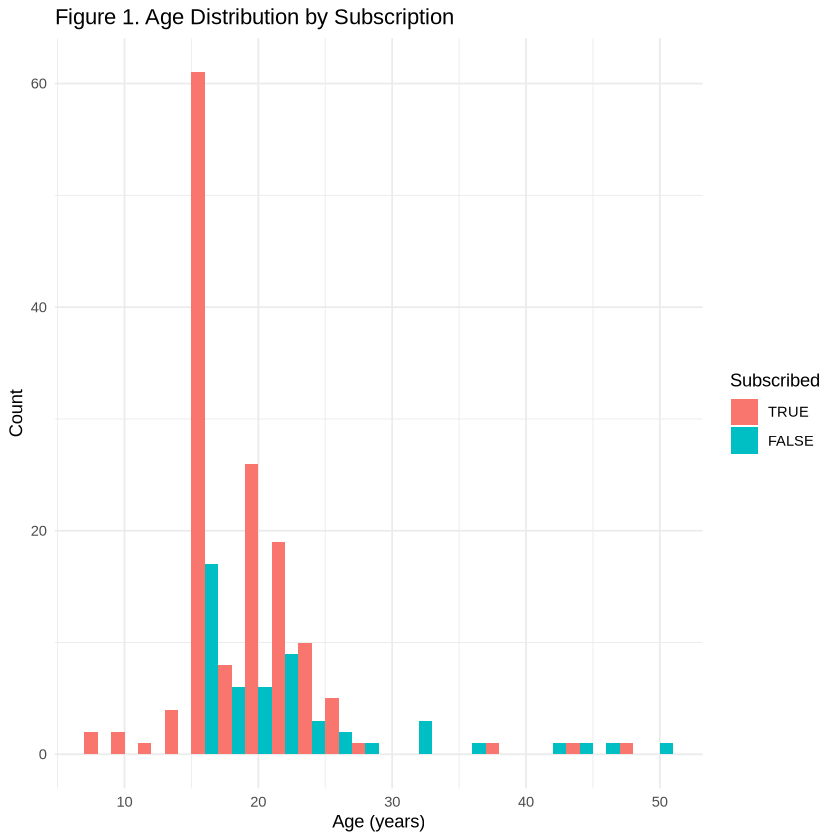

In [14]:
ggplot(players_clean, aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 2, position = "dodge") +
  labs(title = "Figure 1. Age Distribution by Subscription",
       x = "Age (years)", y = "Count", fill = "Subscribed") +
  theme_minimal()

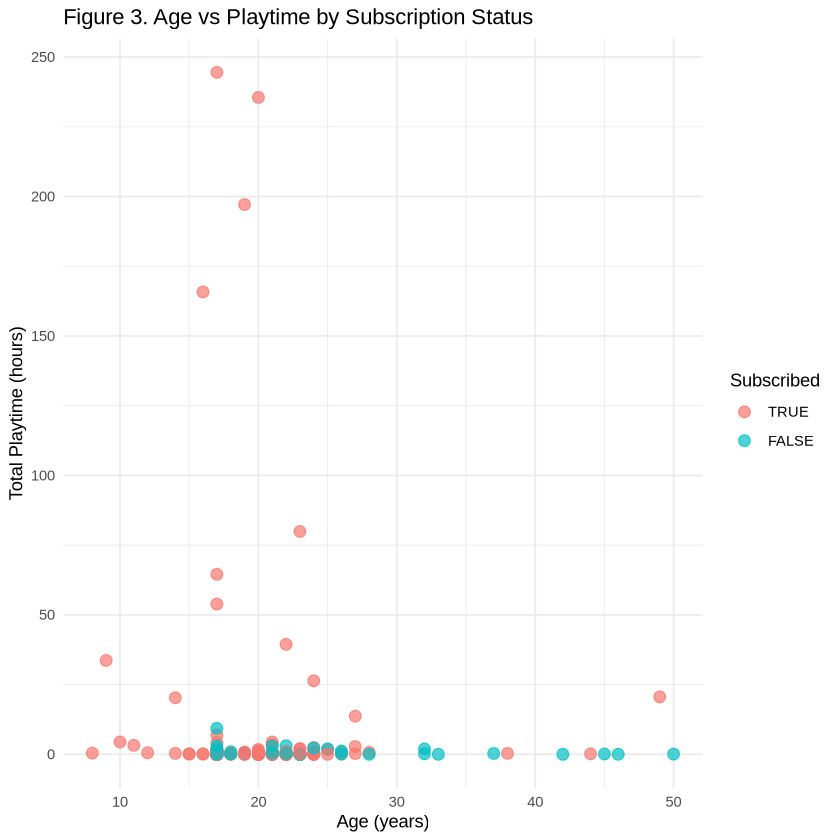

In [15]:
ggplot(players_clean, aes(x = Age, y = calculated_played_hours, color = subscribe)) +
  geom_point(alpha = 0.7, size = 3) +
  labs(title = "Figure 3. Age vs Playtime by Subscription Status",
       x = "Age (years)", y = "Total Playtime (hours)", color = "Subscribed") +
  theme_minimal()

Insight: While there's no strong linear relationship, younger players with more playtime are clearly more likely to subscribe.

3. Modeling Approach
We used k-nearest neighbors classification (kknn) to predict newsletter subscription. This method is well-suited for small to medium datasets, handles both categorical and numeric variables, and doesn't assume linearity.

Why this method?

Easy to interpret: class prediction is based on "closest" examples.

Works well when similar individuals are expected to behave similarly.

Assumptions & Limitations:

Sensitive to variable scale → we centered and scaled numeric predictors.

Model performance depends heavily on choice of k.



4. Data Splitting and Preprocessing
We split the data into training (75%) and testing (25%) sets using stratified sampling based on subscribe. Numeric predictors were scaled and centered.

In [16]:
set.seed(2025)
split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
train <- training(split)
test <- testing(split)

recipe_sub <- recipe(subscribe ~ Age + gender + experience + calculated_played_hours, data = train) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

5. Model Tuning and Evaluation
We tuned the k parameter from 1 to 10 using 5-fold cross-validation to find the best-performing model.


In [18]:

folds <- vfold_cv(train, v = 5, strata = subscribe)

k_grid <- tibble(neighbors = 1:10)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_results <- workflow() |>
  add_recipe(recipe_sub) |>
  add_model(knn_spec) |>
  tune_grid(resamples = folds, grid = k_grid) |>
  collect_metrics()

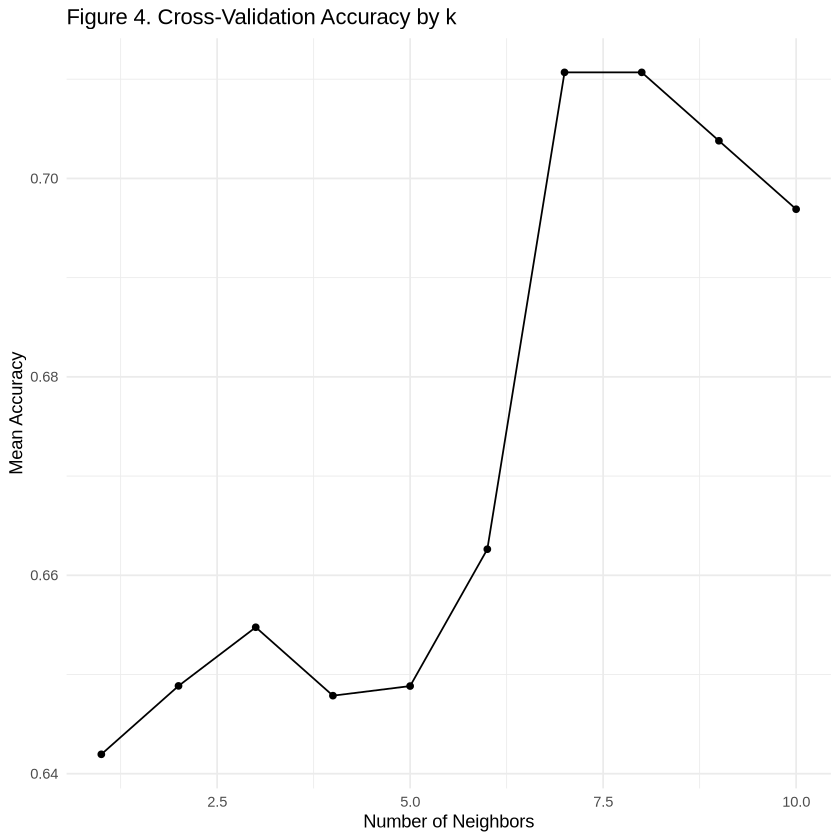

In [19]:
knn_results |>
  filter(.metric == "accuracy") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line() +
  geom_point() +
  labs(title = "Figure 4. Cross-Validation Accuracy by k",
       x = "Number of Neighbors", y = "Mean Accuracy") +
  theme_minimal()

Insight: Accuracy peaked at k = X (replace with best k), which we selected for our final model.

6. Final Model and Results
We trained a final model using the best value of k, then predicted on the test set.


In [21]:
best_k <- knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_fit <- workflow() |>
  add_recipe(recipe_sub) |>
  add_model(final_spec) |>
  fit(data = train)

# Predictions and evaluation
test_preds <- predict(final_fit, test) |>
  bind_cols(test)

test_preds |>
  metrics(truth = subscribe, estimate = .pred_class)

test_preds |>
  conf_mat(truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776
kap,binary,0.1047503


          Truth
Prediction TRUE FALSE
     TRUE    31    10
     FALSE    5     3

###  Model Performance & Results

After performing 5-fold cross-validation on a grid of \( k \) values ranging from 1 to 30, the model achieved its best performance with **\( k = 5 \)**. The highest observed classification accuracy was **0.694**, indicating that approximately 69.4% of the subscription statuses were correctly predicted.

The confusion matrix shows that the model performed better at identifying subscribed players than unsubscribed ones — correctly predicting 31 subscribed players and only 3 unsubscribed ones. 

###  Discussion

Our analysis aimed to predict whether a player would subscribe to the newsletter based on their age, gender, gaming experience, and total playtime using a k-nearest neighbors (k-NN) classification model. The best performing model achieved an accuracy of **69.4%**, with a relatively low Kappa value of **0.105**, indicating that while the model is somewhat predictive, it struggles especially with identifying non-subscribers.

This outcome was somewhat expected. Playtime and experience seem intuitively related to engagement, which could influence subscription behavior. However, the limited performance suggests that the features we used only partially capture the decision to subscribe — and that factors like motivation, in-game behavior, or communication preferences may play a bigger role.

These findings could help game developers recognize that simple demographic or usage metrics may not be sufficient to predict user engagement through subscriptions. It might encourage them to track more nuanced behavioral data or user feedback.
